In [334]:
import json
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
def load_df(csv_path='train.csv', nrows=None) -> pd.DataFrame:
    """
        JSON 형태로 되어있는 컬럼들을 모아서 DataFrame형태로 바꾸는 함수
        converters : JSON 컬럼들의 값들을 json_loads로 데이터 프레임화 시키는 함수를 적용하는 파라미터
        dtype : 데이터를 불러올 때 fullVisitorId의  dtype을 미리 str로 정의
        nrows :  limit와 같은 존재 너무 크면 오래걸리니까 2만으로 줄임.
    """
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, 
                     nrows=nrows)
    '''
    normalize는 json을 정규화(평평하게)만드는 것이며 이는 중첩된 구조를 하나의 테이블로 펼쳐서, 각각의 요소를 행으로 나타내는 것
    흔히 우리가 아는 테이블의 형태로 나타나게 된다. 
    새로운 컬럼을 for문을 통해서 각 column마다 서브 column name으로 할당
    정규화 되기 전 컬럼은 삭제하고, 새로운 컬럼으로 덮어씌운다.
    '''
    for column in JSON_COLUMNS:
        column_as_df = pd.json_normalize(df[column])
        column_as_df.columns = [f"{column}_{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    return df

df = load_df(nrows=20000)

## DROP

In [335]:
drop_columns = ['socialEngagementType', 'device_browser', 'device_browserVersion', 'device_browserSize', 'device_operatingSystem', 'device_operatingSystemVersion', 'device_mobileDeviceBranding', 'device_mobileDeviceModel', 'device_mobileInputSelector', 'device_mobileDeviceInfo', 'device_mobileDeviceMarketingName', 'device_flashVersion', 'device_language', 'device_screenColors', 'device_screenResolution', 'geoNetwork_subContinent', 'geoNetwork_region', 'geoNetwork_metro', 'geoNetwork_city', 'geoNetwork_cityId', 'geoNetwork_networkDomain', 'geoNetwork_latitude', 'geoNetwork_longitude', 'geoNetwork_networkLocation', 'trafficSource_adwordsClickInfo.criteriaParameters', 'trafficSource_referralPath', 'trafficSource_adwordsClickInfo.page', 'trafficSource_adwordsClickInfo.gclId', 'trafficSource_adwordsClickInfo.isVideoAd', 'trafficSource_adContent']
df =df.drop(drop_columns,axis=1)

In [336]:
df.totals_visits.unique()

array(['1'], dtype=object)

## 전처리
### str 변환 함수

In [337]:
def transform_str (df:pd.DataFrame)-> pd.DataFrame:
    """
        str 형태로 변환하는 함수
    """
    transform_str_columns = ['fullVisitorId','sessionId','visitId']
    df[transform_str_columns]=df[transform_str_columns].astype(str)
    return df

transform_str(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 24 columns):
 #   Column                                        Non-Null Count  Dtype 
---  ------                                        --------------  ----- 
 0   channelGrouping                               20000 non-null  object
 1   date                                          20000 non-null  int64 
 2   fullVisitorId                                 20000 non-null  object
 3   sessionId                                     20000 non-null  object
 4   visitId                                       20000 non-null  object
 5   visitNumber                                   20000 non-null  int64 
 6   visitStartTime                                20000 non-null  int64 
 7   device_isMobile                               20000 non-null  bool  
 8   device_deviceCategory                         20000 non-null  object
 9   geoNetwork_continent                          20000 non-null  object
 10

In [338]:
df['date'] =pd.to_datetime(df['date'])
df['visitStartTime']=pd.to_datetime(df['visitStartTime'],unit='s')

### str->int 변환 함수
-  totals_visits은 1로만 차있는 데이터라서 변환이 필요 없음.

In [339]:
def change_numeric(df:pd.DataFrame)-> pd.DataFrame :
    '''
        결측치를 처리하고 문자열-> int형으로 형변환하는 함수
    '''
    transform_int_columns = ['totals_hits','totals_pageviews','totals_bounces','totals_newVisits','totals_transactionRevenue']
    df[transform_int_columns]=df[transform_int_columns].fillna(0)
    df[transform_int_columns]= df[transform_int_columns].astype(int)
    return df 
    
df=change_numeric(df)
df.describe()


,date,visitNumber,visitStartTime,totals_hits,totals_pageviews,totals_bounces,totals_newVisits,totals_transactionRevenue
count,20000,20000.000000,20000,20000.000000,20000.000000,20000.000000,20000.000000,2.000000e+04
mean,1970-01-01 00:00:00.020166769,2.270500,2017-01-11 12:18:57.238799872,4.635700,3.863350,0.524150,0.772600,1.608396e+06
min,1970-01-01 00:00:00.020160811,1.000000,2016-08-11 07:00:13,1.000000,1.000000,0.000000,0.000000,0.000000e+00
25%,1970-01-01 00:00:00.020160902,1.000000,2016-09-03 03:07:57.750000128,1.000000,1.000000,0.000000,1.000000,0.000000e+00
50%,1970-01-01 00:00:00.020170126,1.000000,2017-01-26 14:21:35,1.000000,1.000000,1.000000,1.000000,0.000000e+00
75%,1970-01-01 00:00:00.020170312,1.000000,2017-03-12 21:43:20.249999872,4.000000,4.000000,1.000000,1.000000,0.000000e+00
max,1970-01-01 00:00:00.020170623,389.000000,2017-06-24 06:59:47,331.000000,197.000000,1.000000,1.000000,1.698580e+09
std,NaN,9.113527,NaN,9.830443,7.051905,0.499429,0.419163,2.755843e+07


<Axes: xlabel='totals_bounces'>

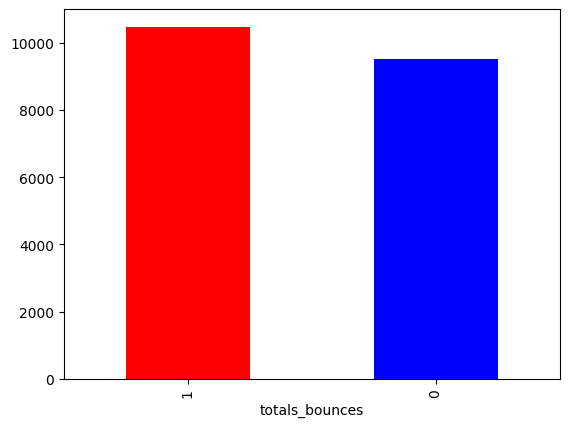

In [340]:
df['totals_bounces'].value_counts().plot.bar(color=['red','blue'])

### Revenue

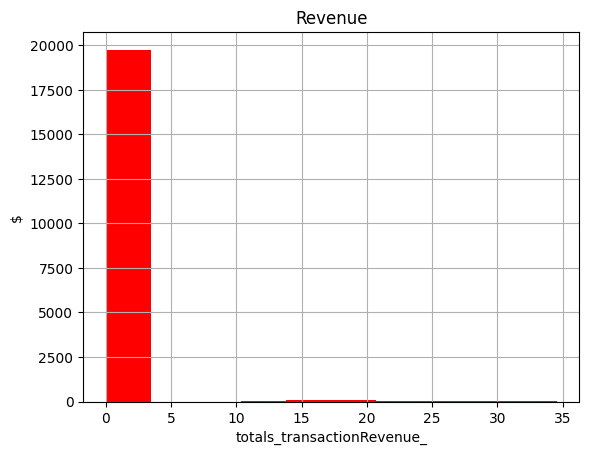

In [341]:
totals_transactionRevenue_median = df[df['totals_transactionRevenue'] != 0]['totals_transactionRevenue'].median()

df['totals_transactionRevenue'] = df['totals_transactionRevenue'].fillna(totals_transactionRevenue_median)

df['totals_transactionRevenue']=np.power(df['totals_transactionRevenue'],1/6).round(2)

df['totals_transactionRevenue'].hist(color='red')
plt.xlabel('totals_transactionRevenue_')
plt.ylabel('$')
plt.title('Revenue')
plt.show()

### ChannelGrouping

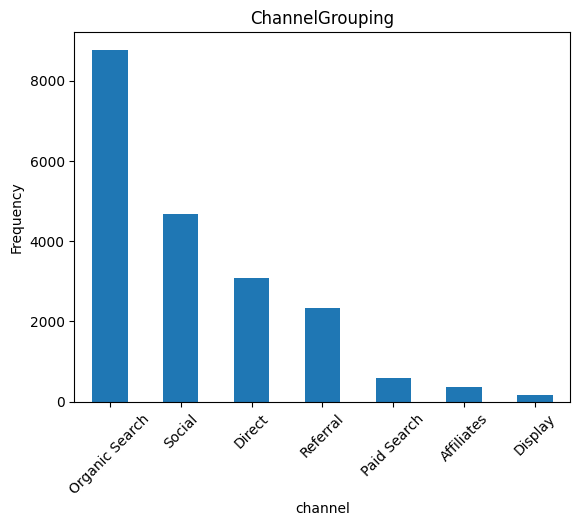

In [342]:
df.channelGrouping.value_counts().plot.bar()
plt.xlabel('channel')
plt.ylabel('Frequency')
plt.title('ChannelGrouping')
plt.xticks(rotation=45)
plt.show()

### GeoNetwork_continent

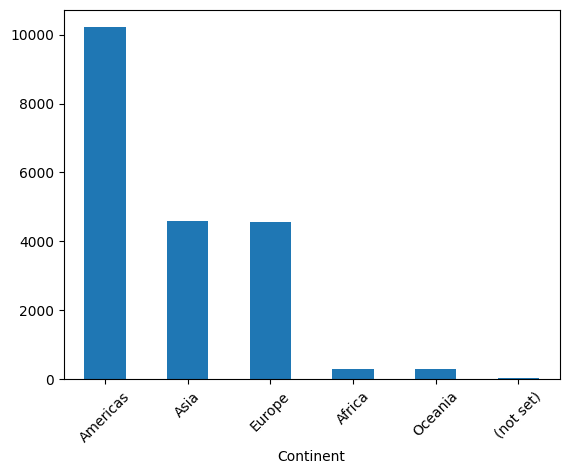

In [343]:
df.geoNetwork_continent.value_counts().plot.bar()
plt.xlabel('Continent')
plt.xticks(rotation=45)
plt.show()

In [344]:
result_df = df.groupby(df['channelGrouping'])['trafficSource_source'].value_counts().sort_values(ascending=False)
result_df

channelGrouping  trafficSource_source
Organic Search   google                  8650
Social           youtube.com             4484
Direct           (direct)                3090
Referral         mall.googleplex.com     1521
Paid Search      google                   595
                                         ... 
Referral         google.pl                  1
                 google.ru                  1
                 gophergala.com             1
                 gsuite.google.com          1
Social           plus.google.com            1
Name: count, Length: 89, dtype: int64

### DAU

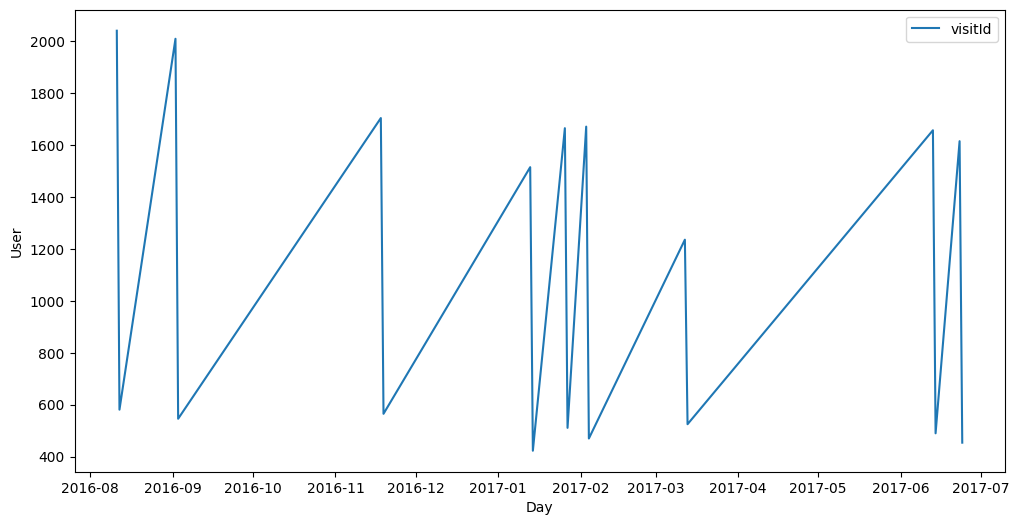

In [345]:
df['date_of_Day']=df.visitStartTime.dt.date
df_DAU=df.groupby(df['date_of_Day'])['visitId'].nunique()
plt.figure(figsize=(12,6))
df_DAU.plot(kind='line',legend='visitId')
plt.xlabel('Day')
plt.ylabel('User')
plt.legend()

### WAU

date_of_Week
2016-08-08/2016-08-14    2620
2016-08-29/2016-09-04    2554
2016-11-14/2016-11-20    2268
2017-01-09/2017-01-15    1937
2017-01-23/2017-01-29    2175
2017-01-30/2017-02-05    2140
2017-03-06/2017-03-12    1235
2017-03-13/2017-03-19     525
2017-06-12/2017-06-18    2146
2017-06-19/2017-06-25    2068
Freq: W-SUN, Name: visitId, dtype: int64


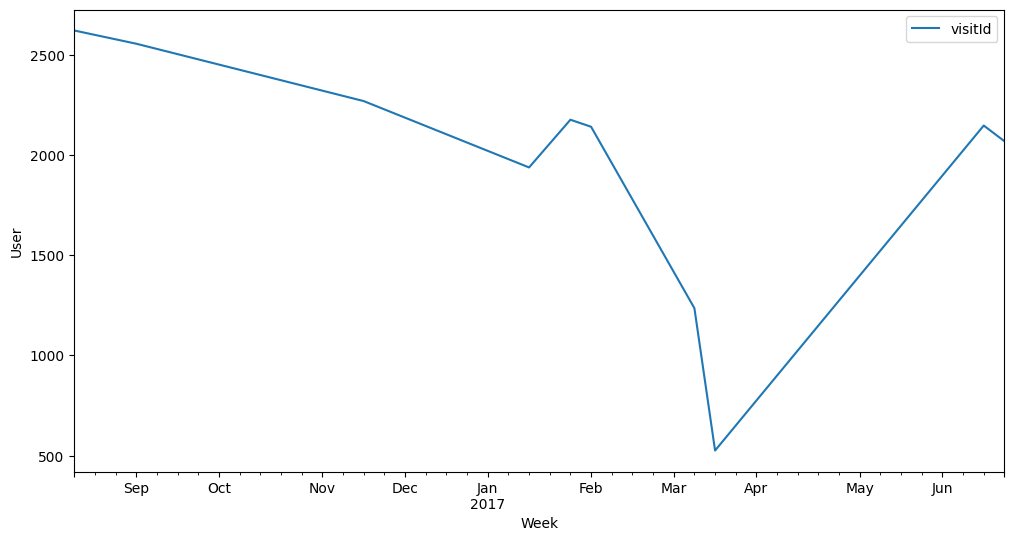

In [346]:
df['date_of_Week']=df.visitStartTime.dt.to_period('W')
df_WAU=df.groupby(df['date_of_Week'])['visitId'].nunique()
plt.figure(figsize=(12,6))
df_WAU.plot(kind='line',legend='visitId')
plt.xlabel('Week')
plt.ylabel('User')
plt.legend()
print(df_WAU)

### DAU

date_of_Month
2016-08    2620
2016-09    2554
2016-11    2268
2017-01    4112
2017-02    2140
2017-03    1760
2017-06    4214
Freq: M, Name: visitId, dtype: int64


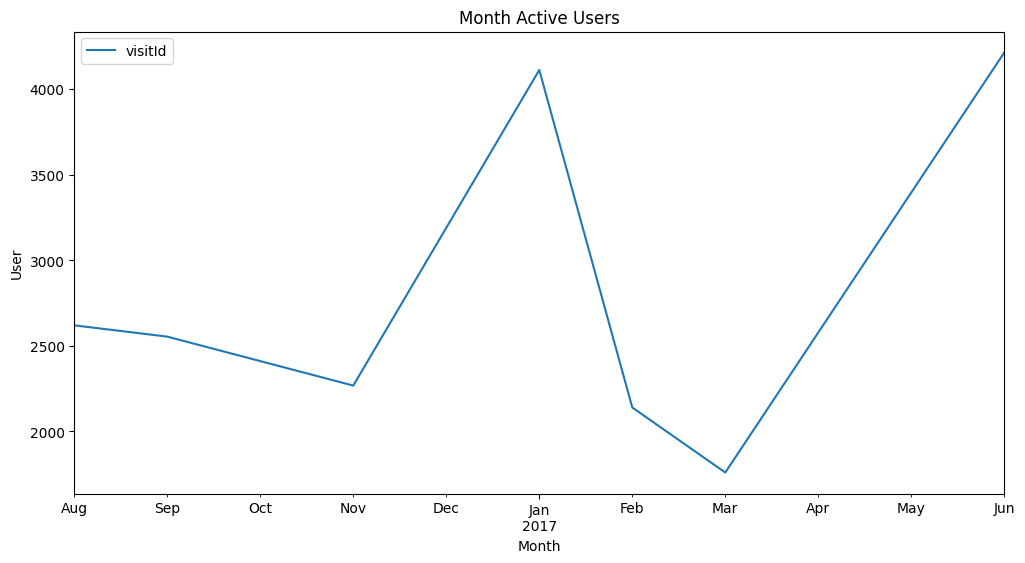

In [347]:
df['date_of_Month']=df.visitStartTime.dt.to_period('M')
df_MAU=df.groupby(df['date_of_Month'])['visitId'].nunique()
plt.figure(figsize=(12,6))
df_MAU.plot(kind='line',legend='visitId')
plt.xlabel('Month')
plt.ylabel('User')
plt.legend()
plt.title('Month Active Users')
print(df_MAU)

In [348]:
# 이게 1.0이 나오면 안되는데,,
DAU_MAU_RATIO=df_DAU.sum() / df_MAU.sum()
DAU_MAU_RATIO

1.0